### Importing the libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import LSTM, Dense, Bidirectional, Input, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, BatchNormalization, MaxPool1D
from keras.models import Model, Sequential
from keras.utils import to_categorical

from tensorflow.keras.utils import plot_model

import re, string, unicodedata, os
from string import punctuation

from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import torch
import transformers
import gensim

In [2]:
df = pd.read_csv('IMDB Dataset.csv', error_bad_lines=False)

<ipython-input-2-bd3660392bb5>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('IMDB Dataset.csv', error_bad_lines=False)


In [3]:
df=pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Data Cleaning

In [4]:
# remove duplicated reviews
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)

(49582, 2)


In [5]:
# Text preprocessing
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    text = re.sub(r'\W', ' ', text) # Remove all the special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) # Remove single characters from the start
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Substituting multiple spaces with single space
    return text
df['review'] = df['review'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Converting sentences into tokens

In [6]:
# The maximum number of words to be used. (most frequent)
max_words = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Found 101702 unique tokens.
Shape of data tensor: (49582, 250)


### Train test split

In [7]:
# Converting categorical labels to numbers.
Y = pd.get_dummies(df['sentiment']).values
print('Shape of label tensor:', Y.shape)

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of label tensor: (49582, 2)
(39665, 250) (39665, 2)
(9917, 250) (9917, 2)


### CNN + LSTM

In [8]:
embeddings = 256

model= keras.Sequential()
model.add(Embedding(max_words,embeddings,input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(256,10,activation='relu'))
model.add(keras.layers.Bidirectional(LSTM(128,return_sequences=True)))
model.add(LSTM(64))
model.add(keras.layers.Dropout(0.4))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 256)          12800000  
                                                                 
 conv1d (Conv1D)             (None, 241, 256)          655616    
                                                                 
 bidirectional (Bidirection  (None, 241, 256)          394240    
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                        

In [9]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(X_train,Y_train, validation_data=(X_test,Y_test),epochs=5, batch_size=32)

Epoch 1/5
1240/1240 [==============================] - 852s 683ms/step - loss: 0.3549 - accuracy: 0.8480 - val_loss: 0.2908 - val_accuracy: 0.8826
Epoch 2/5
1240/1240 [==============================] - 849s 685ms/step - loss: 0.1581 - accuracy: 0.9421 - val_loss: 0.3252 - val_accuracy: 0.8845
Epoch 3/5
1240/1240 [==============================] - 845s 681ms/step - loss: 0.0566 - accuracy: 0.9819 - val_loss: 0.3609 - val_accuracy: 0.8879
Epoch 4/5
1240/1240 [==============================] - 841s 678ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.4726 - val_accuracy: 0.8764
Epoch 5/5
1240/1240 [==============================] - 845s 682ms/step - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.4871 - val_accuracy: 0.8764


In [12]:
# Evaluate the model on the test set
print("Model Performance on test set")
result = model.evaluate(X_test,Y_test)
print(dict(zip(model.metrics_names, result)))
print("Accuracy: %.2f%%" % (result[1]*100))

Model Performance on test set
310/310 [==============================] - 52s 168ms/step - loss: 0.4871 - accuracy: 0.8764
{'loss': 0.48709216713905334, 'accuracy': 0.8763738870620728}
Accuracy: 87.64%


### Model Evaluation

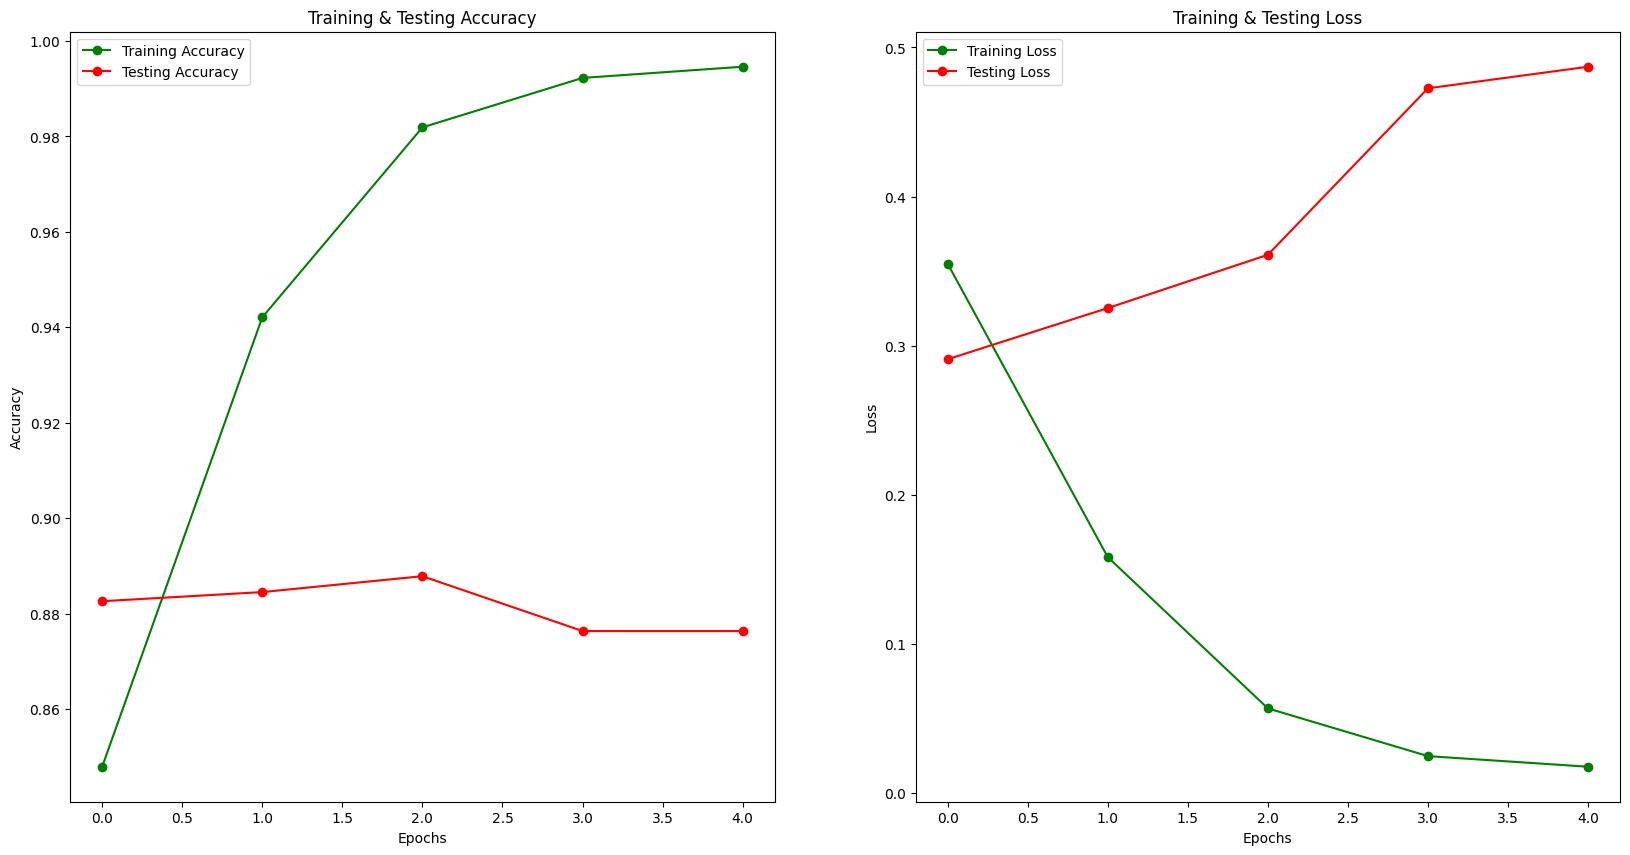

In [13]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [15]:
pred = model.predict(X_test)
pred = np.round(pred).astype(int)
print(classification_report(Y_test, pred, target_names = ['Bad Reviews','Good Reviews']))

310/310 [==============================] - 53s 169ms/step
              precision    recall  f1-score   support

 Bad Reviews       0.86      0.90      0.88      4939
Good Reviews       0.90      0.85      0.87      4978

   micro avg       0.88      0.88      0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917
 samples avg       0.88      0.88      0.88      9917



In [16]:
#calculating precision and reall
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(Y_test, pred, average='micro')
recall = recall_score(Y_test, pred, average='micro')
f1 = f1_score(Y_test, pred, average='micro')
print("Precision: ", round(precision*100,4),'%')
print("Recall: ", round(recall*100,4),'%')
print("f1_score: ", round(f1*100,4), '%')

Precision:  87.6374 %
Recall:  87.6374 %
f1_score:  87.6374 %
